In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression

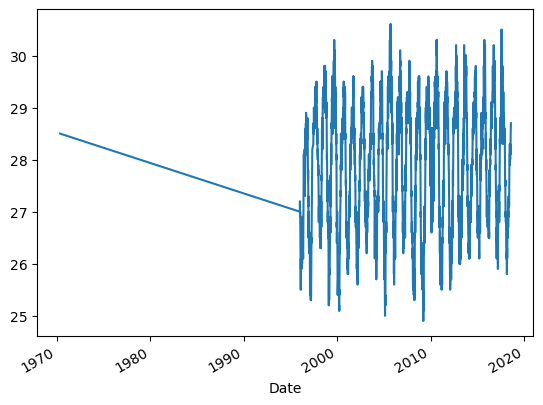

In [127]:
temperature = pd.read_csv('new_temp.csv')
temperature['Date'] = pd.to_datetime(temperature['Date'])
temperature.set_index('Date', inplace=True)
temperature['Temp'].values
temperature = temperature.convert_dtypes(convert_floating=True)
temperature['Temp'] = temperature['Temp'].replace('nd', pd.NA).astype(float)
nan_rows = temperature[temperature['Temp'].isna()].index

# Forward fill NaN values
temperature_forward = temperature.fillna(method='ffill')

#backward fill NaN values
temperature_backward = temperature.fillna(method='bfill')

# Take the average of forward filled and backward filled DataFrames
temperature = (temperature_forward + temperature_backward) / 2





temperature['Temp'].plot()
plt.show()





<Axes: xlabel='Date'>

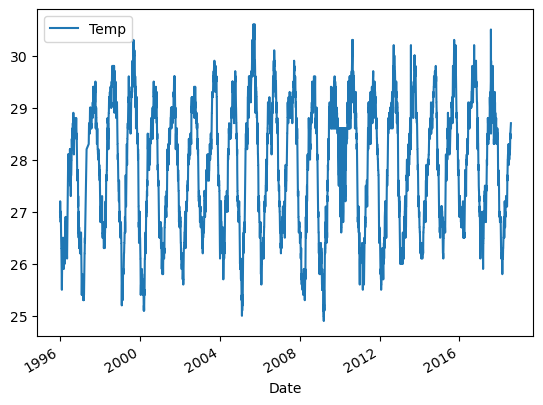

In [128]:
temperature_truncate = temperature.sort_index().truncate(before = '1995-01-01')
# trends = seasonal_decompose(temperature['Temp'], model = 'additive', period = 365)
# trends.plot()
# plt.show()
temperature_truncate.plot()

/var/folders/9t/wltz5rw540dg7_k5xs930j_c0000gn/T/ipykernel_13926/3739817702.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  a_few_days = temperature_truncate[(temperature_truncate.index.date >= start_day) & (temperature_truncate.index.date <= end_day)]


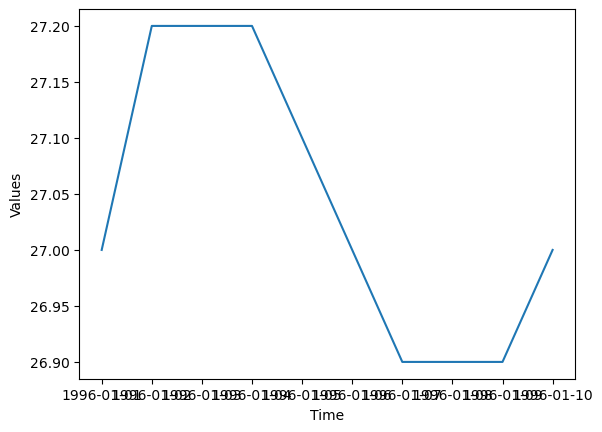

In [129]:
start_day = pd.to_datetime('1996-01-01')
end_day = pd.to_datetime('1996-01-10')

a_few_days = temperature_truncate[(temperature_truncate.index.date >= start_day) & (temperature_truncate.index.date <= end_day)]

# Plot the data
plt.plot(a_few_days.index, a_few_days.values)  # Plotting time against values
plt.xlabel('Time')
plt.ylabel('Values')
#plt.title('Data for {}'.format(start_day, end_day))
plt.show()

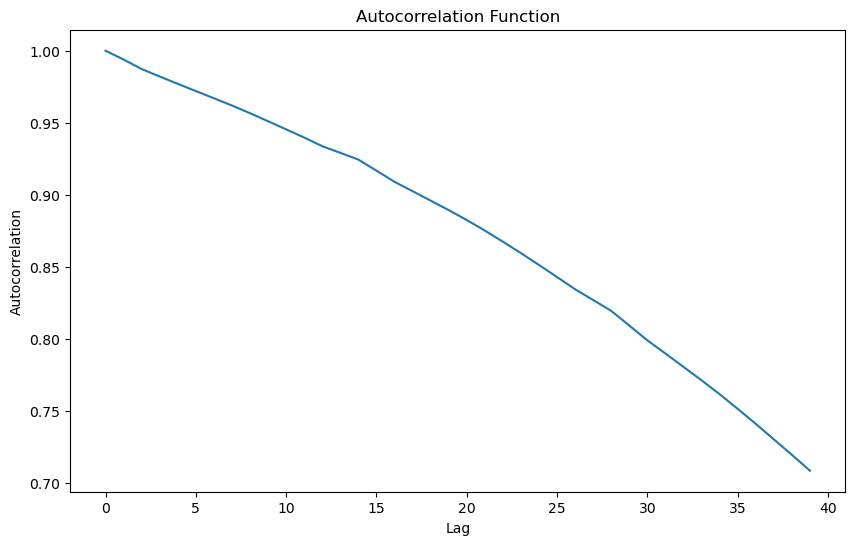

In [130]:
auto_corr = acf(temperature['Temp'])
auto_corr

plt.figure(figsize=(10, 6))
plt.plot(auto_corr)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


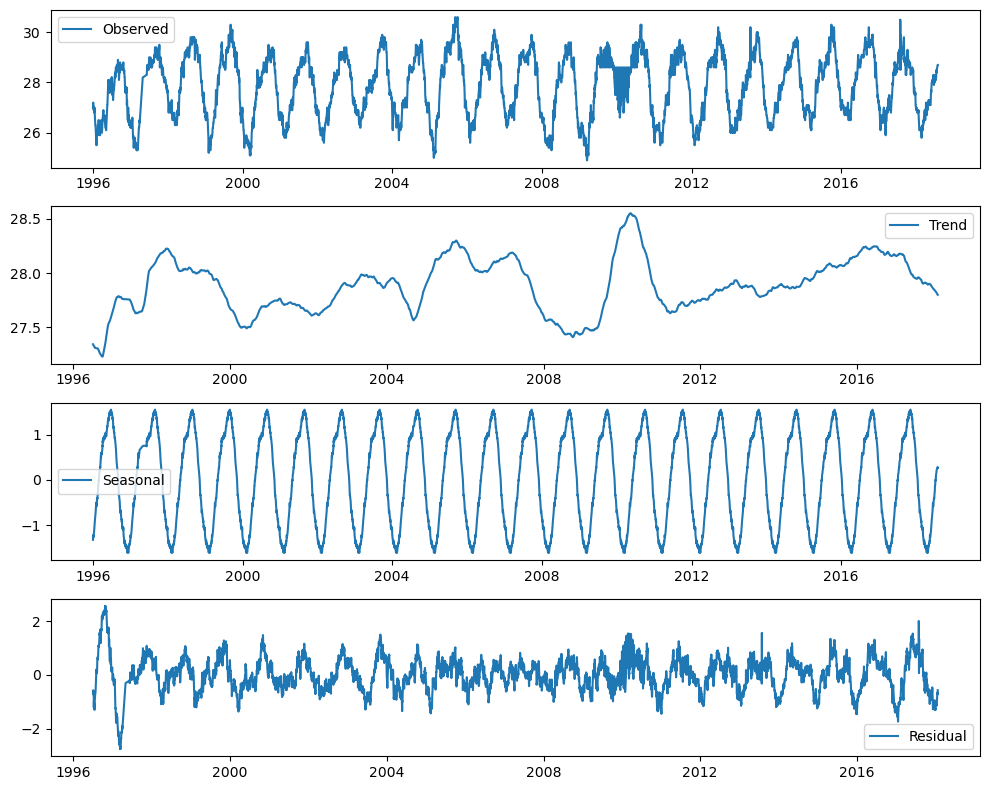

In [153]:
trends = seasonal_decompose(temperature_truncate['Temp'], model = 'additive', period = 365)
# trends.plot()
# plt.show()

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
#plt.plot(trend_predicted, label='Regression Line', linestyle='--')
plt.plot(trends.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual')
plt.legend()

plt.savefig('water_temp_decomp.png')
plt.tight_layout()
plt.show()

In [118]:
#calculate the moving average
move_average = temperature_truncate.rolling(window = 365).mean()[364:]
move_average

,Temp
Date,
1996-12-30,27.342740
1996-12-31,27.340822
1997-01-01,27.338082
1997-01-02,27.335616
1997-01-03,27.333425
...,...
2018-07-21,27.803014
2018-07-22,27.801644
2018-07-30,27.800548


In [119]:
#calculate the detrended time series
detrend = temperature_truncate[364:] - move_average
detrend

,Temp
Date,
1996-12-30,-1.142740
1996-12-31,-1.040822
1997-01-01,-1.138082
1997-01-02,-1.035616
1997-01-03,-0.933425
...,...
2018-07-21,0.596986
2018-07-22,0.698356
2018-07-30,0.899452


In [122]:
#calculate the seasonal component of the time series
season = np.zeros(365) 
for k in range(365):
    season[k] = detrend[k::365].mean()
#extend the period to 365 days
new_season = np.tile(season, len(temperature_truncate[364:])//len(season)+1)[:len(temperature_truncate[364:])]

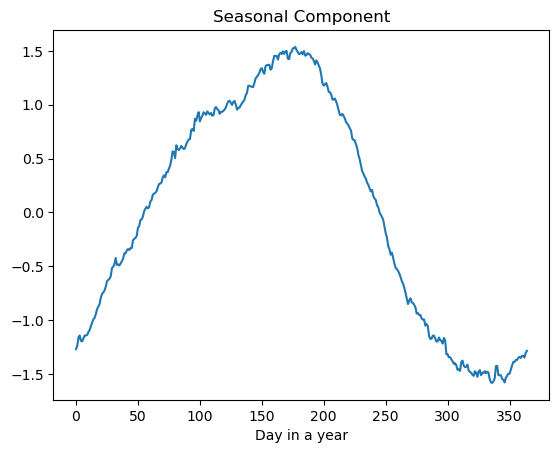

In [124]:
#plot the seasonal component of your time series
plt.plot(season)
plt.xlabel('Day in a year')
plt.title('Seasonal Component')
plt.show()

                Temp
Date                
1996-12-30 -1.142740
1996-12-31 -1.040822
1997-01-01 -1.138082
1997-01-02 -1.035616
1997-01-03 -0.933425
...              ...
2018-07-21  0.596986
2018-07-22  0.698356
2018-07-30  0.899452
2018-07-31  0.900274
2018-08-01  0.901096

[7738 rows x 1 columns]
[-1.26856787 -1.23678705 -1.15951432 ...  0.32646326  0.34429639
  0.32577833]


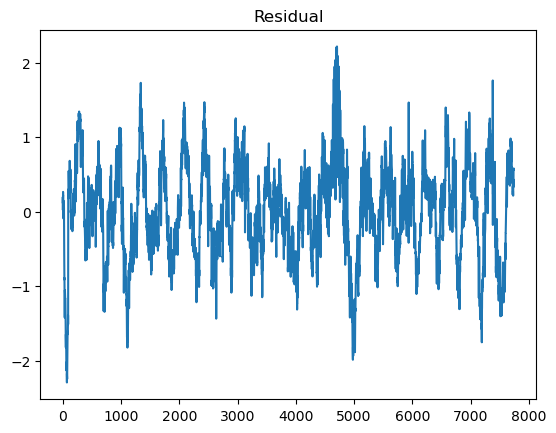

In [132]:
#solve for the time series residual and plot
print(detrend)
print(new_season)
Residual = detrend['Temp'].astype('float') - new_season
plt.plot(np.array(Residual.astype('float')))
plt.title('Residual')
plt.show()

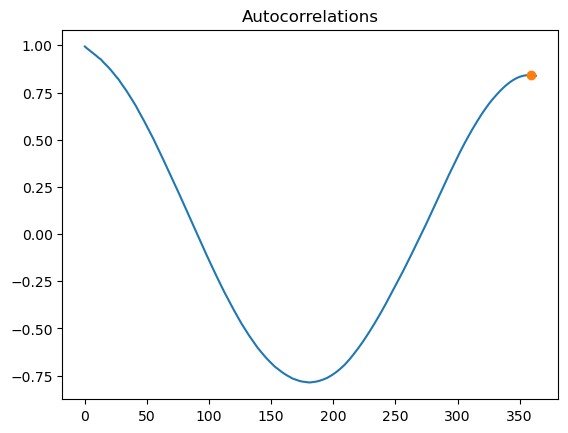

Optimal Periodicity: 359


In [156]:
#plot the autocorrelation of your time series as a function of k
data = [temperature_truncate['Temp'].astype('float').autocorr(lag = k) for k in range(1,365)]
max_index = len(data)//2 +np.argmax(data[len(data)//2:])

plt.plot(data) 
plt.plot(max_index, data[max_index], 'o')
plt.title('Autocorrelations')
plt.show()

print(f'Optimal Periodicity: {max_index}')

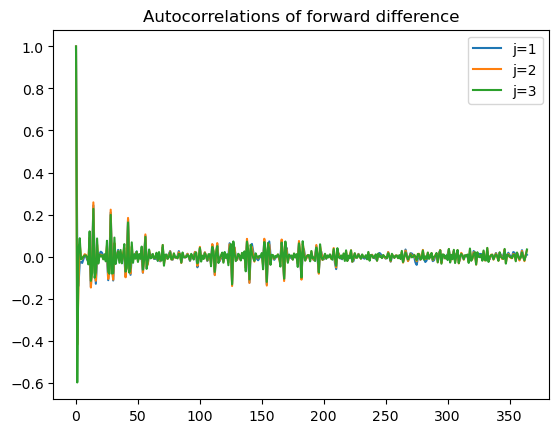

In [138]:
#get the first, second and third order difference quotients
first_diff = Residual.diff(periods = 1)
second_diff = first_diff.diff(periods = 1)
third_diff = second_diff.diff(periods = 1)

#compute the autocorrelation of each time series
auto_cor1 = [first_diff.astype('float').autocorr(lag = k) for k in range(365)] 
auto_cor2 = [second_diff.astype('float').autocorr(lag = k) for k in range(365)] 
auto_cor3 = [third_diff.astype('float').autocorr(lag = k) for k in range(365)]

#plot the autocorrelation
plt.plot(auto_cor1,label = 'j=1')
plt.plot(auto_cor2,label = 'j=2')
plt.plot(auto_cor3,label = 'j=3')
plt.title('Autocorrelations of forward difference')
plt.legend()

# Classical Decomposition of Coral Coverage

In [8]:
coral = pd.read_csv('coral_dataset.csv', index_col='Date')
coral = coral[coral['percentCover_CTB'] != 'nd'] #drop all of the rows with these entries and then print out the amount of rows in our dataset
coral = coral[coral['percentCover_macroalgae'] != 'nd']
coral = coral[coral['percentCover_allCoral'] != 'nd']

In [9]:
columns_to_cast = ['percentCover_CTB', 'percentCover_macroalgae', 'percentCover_allCoral'] #get a list of the columns that we want to cast
coral[columns_to_cast] = coral[columns_to_cast].astype(float) #cast these columns as floats and divide by 100 to make the percents 
coral[columns_to_cast] = coral[columns_to_cast]/100
coral['percentCover_other'] = 1 - (coral['percentCover_CTB']+coral['percentCover_macroalgae']) #add in another column for other types of coral

In [10]:
# convert the date column to date time objects
coral.index = pd.to_datetime(coral.index)
coral

,site,transect,quadrat,percentCover_allCoral,percentCover_macroalgae,percentCover_CTB,percentCover_other
Date,,,,,,,
1987-12-01,Tektite,1,T1Q1,0.165,0.035,0.060,0.905
1987-12-01,Tektite,1,T1Q2,0.100,0.060,0.740,0.200
1987-12-01,Tektite,1,T1Q3,0.135,0.035,0.450,0.515
1987-12-01,Tektite,1,T1Q4,0.155,0.065,0.615,0.320
1987-12-01,Tektite,1,T1Q5,0.190,0.040,0.480,0.480
...,...,...,...,...,...,...,...
2021-07-01,Yawzi,nd,6,0.000,0.300,0.500,0.200
2021-07-01,Yawzi,nd,7,0.000,0.285,0.455,0.260
2021-07-01,Yawzi,nd,8,0.005,0.350,0.350,0.300


In [95]:
all_coral = coral['percentCover_allCoral']

<Axes: xlabel='Date'>

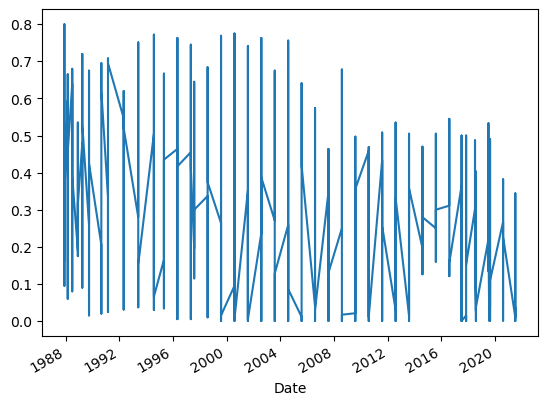

In [96]:
all_coral.plot()

In [97]:
#calculate the moving average
move_average = all_coral.rolling(window = 365).mean()[364:]
move_average

Date
1996-05-01    0.369345
1996-05-01    0.370173
1996-05-01    0.371238
1996-05-01    0.372252
1997-08-01    0.372718
                ...   
2021-07-01    0.062710
2021-07-01    0.062258
2021-07-01    0.061915
2021-07-01    0.061929
2021-07-01    0.062025
Name: percentCover_allCoral, Length: 1900, dtype: float64

In [98]:
#calculate the detrended time series
detrend_coral = all_coral[366:] - move_average
detrend_coral

Date
1987-12-01    0.279521
1987-12-01    0.280170
1987-12-01    0.278822
1987-12-01    0.278003
1987-12-01    0.278000
                ...   
2021-07-01   -0.027710
2021-07-01   -0.027258
2021-07-01   -0.026915
2021-07-01   -0.026929
2021-07-01   -0.027025
Name: percentCover_allCoral, Length: 90794, dtype: float64

In [99]:
#calculate the seasonal component of the time series
season = np.zeros(365) 
for k in range(365):
    season[k] = detrend_coral[k::365].mean()
#extend the period to 365 days
new_season = np.tile(season, len(all_coral[364:])//len(season)+1)[:len(all_coral[364:])]

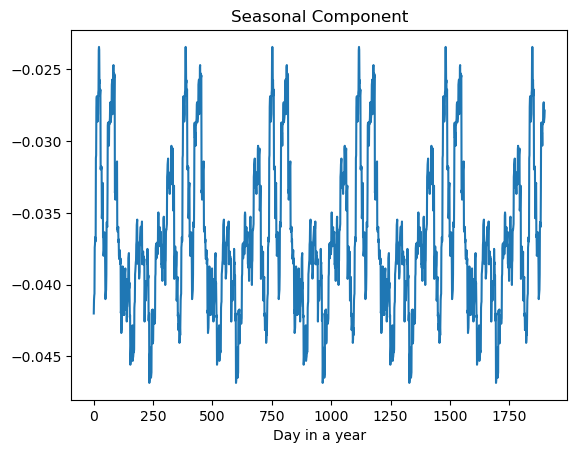

In [100]:
#plot the seasonal component of your time series
plt.plot(new_season)
plt.xlabel('Day in a year')

plt.title('Seasonal Component')
plt.show()

In [101]:
#solve for the time series residual and plot
print(detrend_coral)
print(new_season)
Residual = detrend_coral.astype('float') - new_season
plt.plot(np.array(Residual.astype('float')))
plt.title('Residual')
plt.show()

Date
1987-12-01    0.279521
1987-12-01    0.280170
1987-12-01    0.278822
1987-12-01    0.278003
1987-12-01    0.278000
                ...   
2021-07-01   -0.027710
2021-07-01   -0.027258
2021-07-01   -0.026915
2021-07-01   -0.026929
2021-07-01   -0.027025
Name: percentCover_allCoral, Length: 90794, dtype: float64
[-0.04201116 -0.04106483 -0.04077451 ... -0.02846933 -0.02833661
 -0.02787458]


ValueError: operands could not be broadcast together with shapes (90794,) (1900,) 

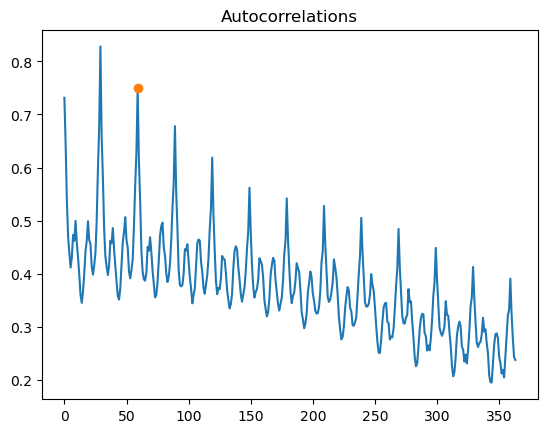

Optimal Periodicity: 59


In [102]:
#plot the autocorrelation of your time series as a function of k
data = [all_coral.astype('float').autocorr(lag = k) for k in range(1,365)]
max_index = 45 +np.argmax(data[45:])

plt.plot(data) 
plt.plot(max_index, data[max_index], 'o')
plt.title('Autocorrelations')
plt.show()

print(f'Optimal Periodicity: {max_index}')

In [103]:
all_coral = all_coral.sort_index()

In [105]:
#all_coral_yawzi
all_coral_tekite = coral[coral['site'] == 'Tektite']
all_coral_tekite = all_coral_tekite['percentCover_allCoral']
all_coral_tekite.astype('float')

all_coral_yawzi = coral[coral['site'] == 'Yawzi']
all_coral_yawzi = all_coral_yawzi['percentCover_allCoral']
all_coral_yawzi.astype('float')

Date
1987-12-01    0.570
1987-12-01    0.230
1987-12-01    0.800
1987-12-01    0.670
1987-12-01    0.481
              ...  
2021-07-01    0.000
2021-07-01    0.000
2021-07-01    0.005
2021-07-01    0.005
2021-07-01    0.035
Name: percentCover_allCoral, Length: 1116, dtype: float64

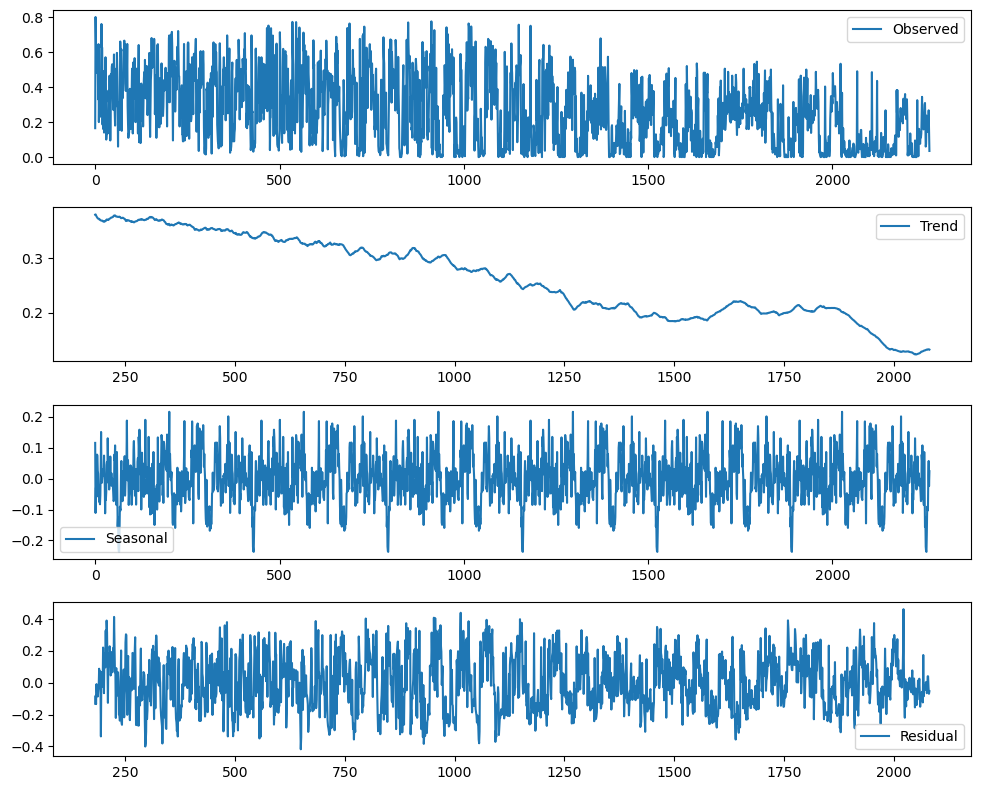

In [146]:
trends_coral = seasonal_decompose(all_coral.sort_index().values, model = 'additive', period = 365)
# trends.plot()
# plt.show()

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends_coral.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(trends_coral.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(trends_coral.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(trends_coral.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

[nan nan nan ... nan nan nan]


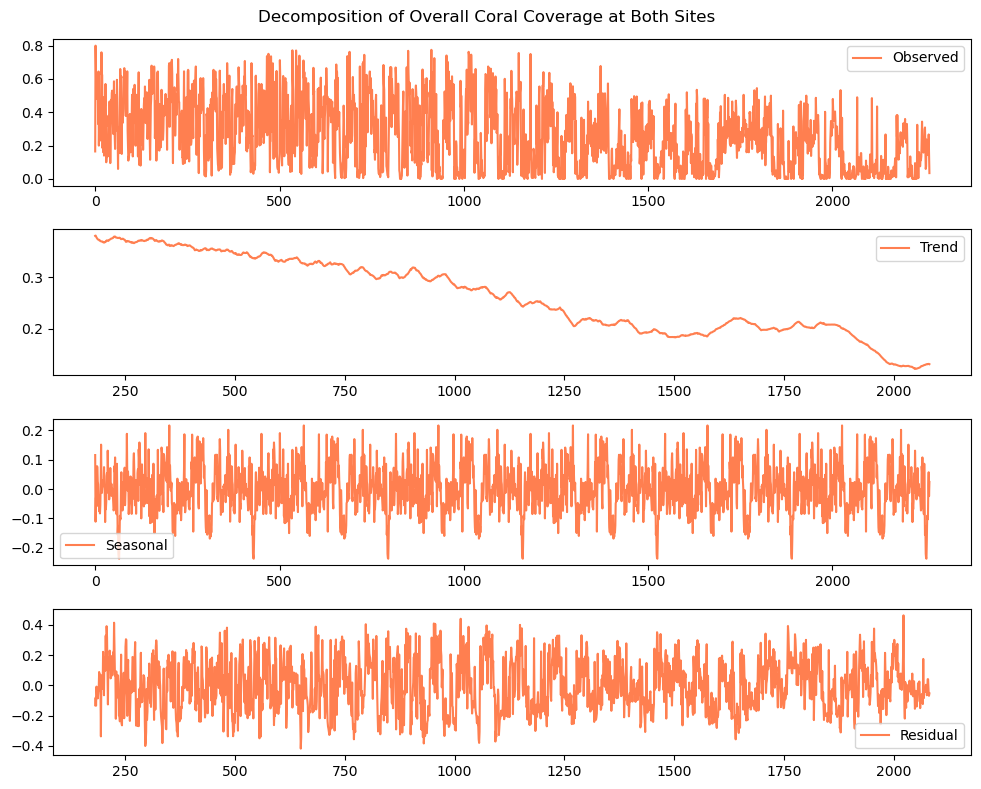

In [120]:
trends = seasonal_decompose(all_coral.sort_index().values, model = 'additive', period = 365)
# trends.plot()
# plt.show()

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends.observed, label='Observed', color = 'coral')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend', color = 'coral')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal', color = 'coral')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual', color = 'coral')
plt.legend()

plt.suptitle('Decomposition of Overall Coral Coverage at Both Sites')
plt.tight_layout()

plt.savefig('Overall_decomp.png')
plt.show()

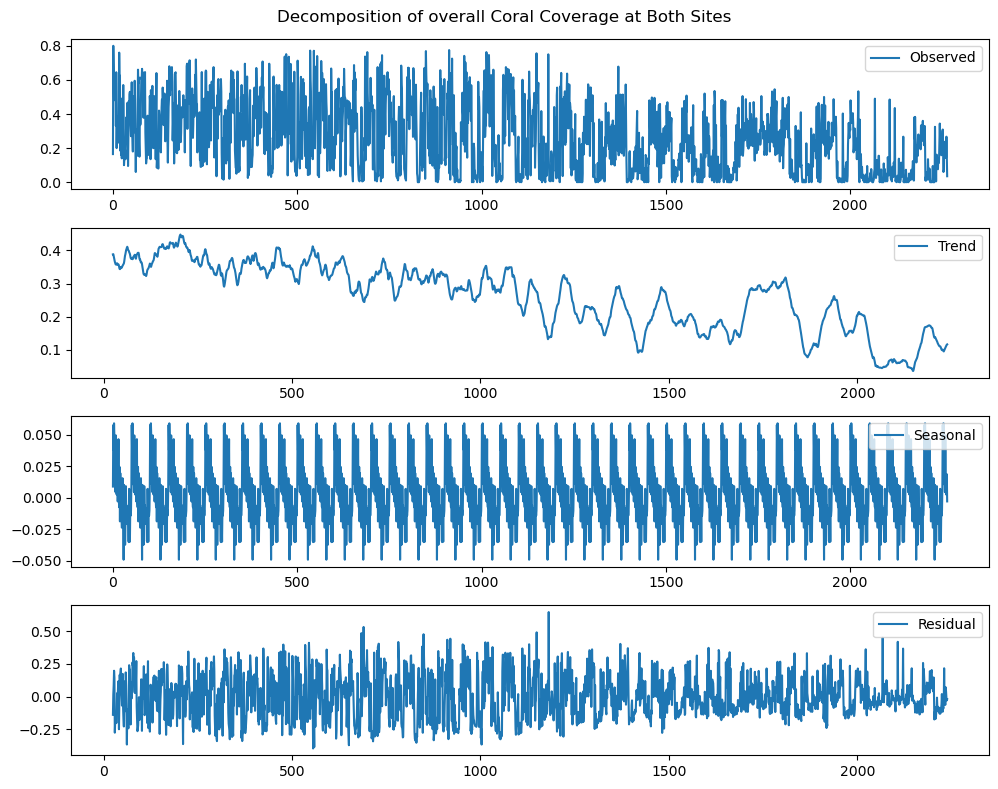

In [121]:
trends = seasonal_decompose(all_coral.sort_index().values, model = 'additive', period = 50)
# trends.plot()
# plt.show()

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual')
plt.legend()

plt.suptitle('Decomposition of overall Coral Coverage at Both Sites')
plt.tight_layout()
plt.show()

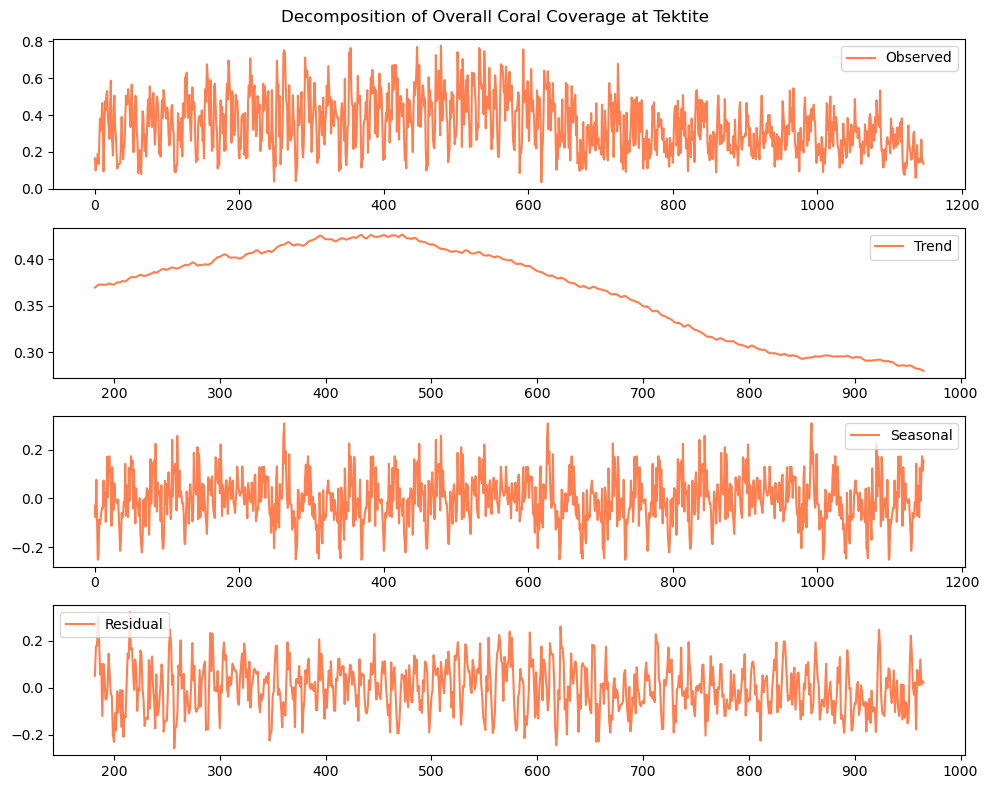

In [122]:
trends = seasonal_decompose(all_coral_tekite.sort_index().values, model = 'additive', period = 365)
# trends.plot()
# plt.show()

# Plot the individual components


plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends.observed, label='Observed', color = 'coral')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend', color = 'coral')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal', color = 'coral')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual', color = 'coral')
plt.legend()

plt.suptitle('Decomposition of Overall Coral Coverage at Tektite')
plt.tight_layout()

plt.savefig('Tektite_decompp.png')
plt.show()

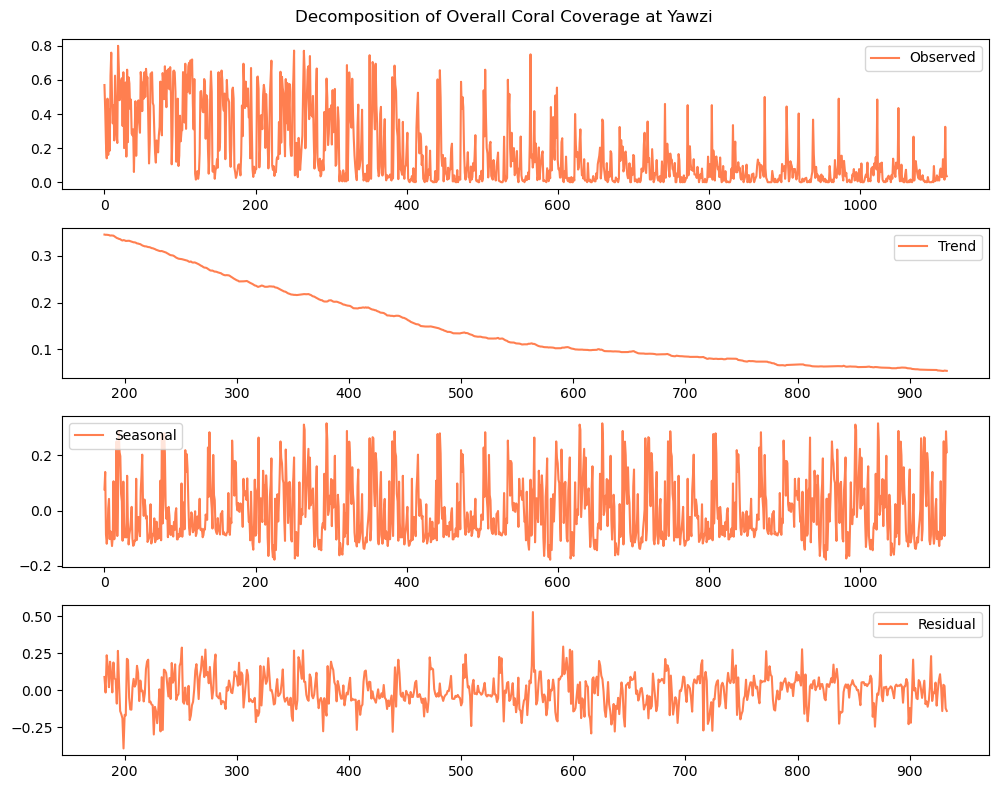

In [123]:
trends = seasonal_decompose(all_coral_yawzi.sort_index().values, model = 'additive', period = 365)
# trends.plot()
# plt.show()

# Plot the individual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(trends.observed, label='Observed', color = 'coral')
plt.legend()

plt.subplot(412)
plt.plot(trends.trend, label='Trend', color = 'coral')
plt.legend()

plt.subplot(413)
plt.plot(trends.seasonal, label='Seasonal', color = 'coral')
plt.legend()

plt.subplot(414)
plt.plot(trends.resid, label='Residual', color = 'coral')
plt.legend()

plt.suptitle('Decomposition of Overall Coral Coverage at Yawzi')
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('Yawzi_decomp.png')
plt.show()